## Planteamiento del problema:

Una empresa desea comprender a sus clientes a través de los datos para modificar los productos de acuerdo con las necesidades, comportamientos e inquietudes específicas de los diferentes tipos de clientes.



## Objetivo: 

En este proyecto, como no tenemos una variable etiquetada que intentamos predecir, utilizare algoritmos no supervisados de ML (K-Means y AgglomerativeClustering) con el objetivo de encontrar patrones dentro de nuestro conjunto de datos y particionarlo en trozos más pequeños o clusters.

Este analisis le permitirá a la empresa  modificar sus productos en función de sus clientes objetivo de diferentes tipos de segmentos de clientes. Por ejemplo, en lugar de gastar dinero para comercializar un nuevo producto para cada cliente de la base de datos de la empresa, puede analizar qué segmento de clientes tiene más probabilidades de comprar el producto y luego comercializarlo sólo en ese segmento en particular.



## Descripción del dataset: 

El dataset esta dividio en 4 grupos de atributos, sumando un total de 29 columnas.

El primer grupo se refiere a datos del cliente como educación,ingreso, estado civil, etc.

El segundo grupo se refiere al total gastado por los clientes en los diferentes productos de la empresa.

El tercer grupo se refiere a las promociones y campañas y como actuaron los clientes frente a las mismas.

El último grupo nos informa sobre el lugar en el cual el cliente compro el producto, por ej el sitio web. 




In [834]:
# Importamos las librerías
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics

import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [835]:
df = pd.read_csv('marketing_campaign.csv', sep="\t")

In [836]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


#### Primer acercamiento a los datos

In [837]:
df.shape

(2240, 29)

In [838]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

Del resultado anterior, podemos concluir y observar que:

Faltan valores en ingresos

Dt_Customer que indica la fecha en que un cliente se unió a la base de datos no esta en formato fecha

In [839]:
print("Categorias Marital_Status:\n", df["Marital_Status"].value_counts(), "\n")
print("Categorias Education:\n", df["Education"].value_counts())

Categorias Marital_Status:
 Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64 

Categorias Education:
 Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: Education, dtype: int64


#### Data cleaning

In [840]:
#Para los valores faltantes, voy a "rellenarlos" con la media del ingreso 
from sklearn.impute import SimpleImputer

# Crear un SimpleImputer con la estrategia de la media
imputer = SimpleImputer(strategy='mean')

# Ajustar el imputer y transformar los datos
df['Income'] = imputer.fit_transform(df[['Income']])



In [841]:
df.isnull().sum()

ID                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Z_CostContact          0
Z_Revenue              0
Response               0
dtype: int64

In [842]:
# cambiar tipo de dato a fecha
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"])

#### Feature Engineering

- Eliminar columnas innecesarias a mi criterio 

- Realizaré los siguientes pasos para diseñar algunas columnas nuevas:

    Extraer la "Edad" de un cliente mediante el "Año_Nacimiento".

    Crear una característica "Gastado" que indica el monto total gastado por el cliente en los diferentes productos.

    Simplificar  la columna "Marital_Status" que solo sea casado o soltero. 

    Crear la columna "Niños" para indicar el total de niños en un hogar, es decir, niños y adolescentes.

    Simplificar en tres categorías en "Educación" 

    Crear una columna con el año de la suscripción
    







In [843]:
df["Age"] = 2024-df["Year_Birth"]

df["Spent"] = df["MntWines"]+ df["MntFruits"]+ df["MntMeatProducts"]+ df["MntFishProducts"]+ df["MntSweetProducts"]+ df["MntGoldProds"]

df["Marital_Status"]=df["Marital_Status"].replace({"Married":"Married", "Together":"Married", "Absurd":"Single", "Alone":"Single",
                                                       "Widow":"Single", "YOLO":"Single", "Divorced":"Single", "Single":"Single",})


df["Children"]=df["Kidhome"]+df["Teenhome"]

df["Education"]=df["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#para identificar mejor los productos
df=df.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

df["year_Dt"] = df['Dt_Customer'].dt.year

#Eliminar algunas de las columnas redundantes
to_drop = [ "Z_CostContact", "Z_Revenue", "Year_Birth", "ID", "Kidhome","Teenhome",'Dt_Customer']
df = df.drop(to_drop, axis=1)

In [844]:
df.columns

Index(['Education', 'Marital_Status', 'Income', 'Recency', 'Wines', 'Fruits',
       'Meat', 'Fish', 'Sweets', 'Gold', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'Age', 'Spent',
       'Children', 'year_Dt'],
      dtype='object')

#### EDA

In [845]:
df.describe()

,Income,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,NumDealsPurchases,NumWebPurchases,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Spent,Children,year_Dt
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,52247.251354,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,...,0.074554,0.072768,0.064286,0.013393,0.009375,0.149107,55.194196,605.798214,0.950446,2013.028125
std,25037.797168,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,...,0.262728,0.259813,0.245316,0.114976,0.096391,0.356274,11.984069,602.249288,0.751803,0.684554
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,28.000000,5.000000,0.000000,2012.000000
25%,35538.750000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,47.000000,68.750000,0.000000,2013.000000
50%,51741.500000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,54.000000,396.000000,1.000000,2013.000000
75%,68289.750000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,65.000000,1045.500000,1.000000,2013.000000
max,666666.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,131.000000,2525.000000,3.000000,2014.000000


Las estadísticas anteriores muestran algunas discrepancias en el ingreso y la edad medios y en el ingreso y la edad máximos.

La edad máxima es 131 años, ya que calculé la edad que tendría hoy (es decir, 2024) y los datos son antiguos.


In [846]:
#Eliminar los valores atípicos estableciendo un límite a la edad y los ingresos.
df = df[(df["Age"]<90)]
df = df[(df["Income"]<600000)]
print("Total de filas con los outliers eliminados:", len(df))

Total de filas con los outliers eliminados: 2236


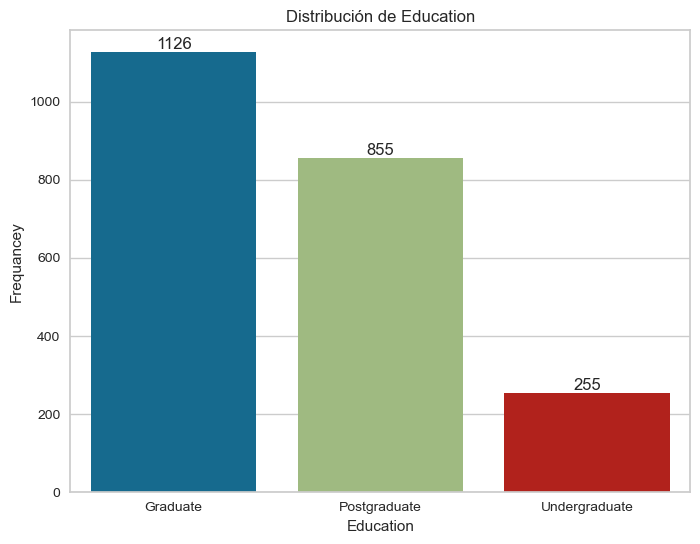

In [847]:
plt.figure(figsize=(8,6))
plt.title("Distribución de Education")
figure = sns.countplot(x= df['Education'])
for contain in figure.containers :
    figure.bar_label(contain)
plt.ylabel("Frequancey")

plt.show()

In [848]:
pd.DataFrame(df.groupby("Education")["Income"].mean()).round(2).sort_values(by="Income")

,Income
Education,
Undergraduate,41894.49
Graduate,52170.51
Postgraduate,54689.75


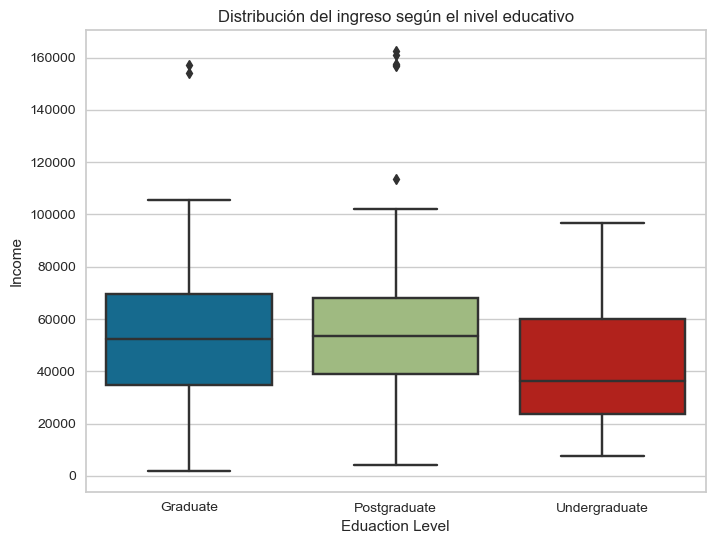

In [849]:
plt.figure(figsize=(8,6))
plt.title("Distribución del ingreso según el nivel educativo")
sns.boxplot(x= df['Education'] , y =df["Income"])

plt.ylabel("Income")
plt.xlabel("Eduaction Level")
plt.show()

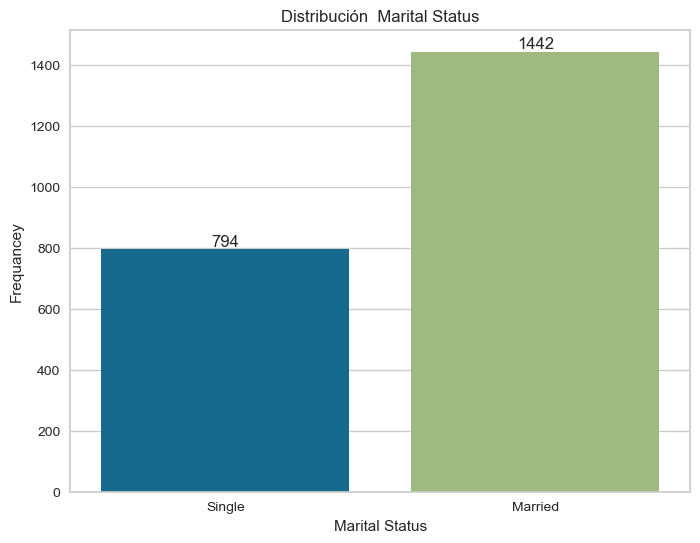

In [850]:
plt.figure(figsize=(8,6))
plt.title("Distribución  Marital Status")
figure = sns.countplot(x= df['Marital_Status'])
for contain in figure.containers :
    figure.bar_label(contain)
plt.ylabel("Frequancey")
plt.xlabel("Marital Status")
plt.show()

In [851]:
pd.DataFrame(df.year_Dt.value_counts()) 

,year_Dt
2013,1186
2014,556
2012,494


Contamos con 3 años de suscripciones, la mayoría en 2013.

In [852]:
# Analisis de lo gastado por producto
cols = df[['Wines', 'Fruits',
       'Meat', 'Fish', 'Sweets',
       'Gold']]


In [853]:
# Calcular el total gastado en cada producto
totals = cols.sum()

# Crear un DataFrame con los totales
totals_df = pd.DataFrame(totals, columns=['Total'])

# Resetear el índice para que los nombres de los productos sean una columna
totals_df.reset_index(inplace=True)
totals_df.columns = ['Product', 'Total']


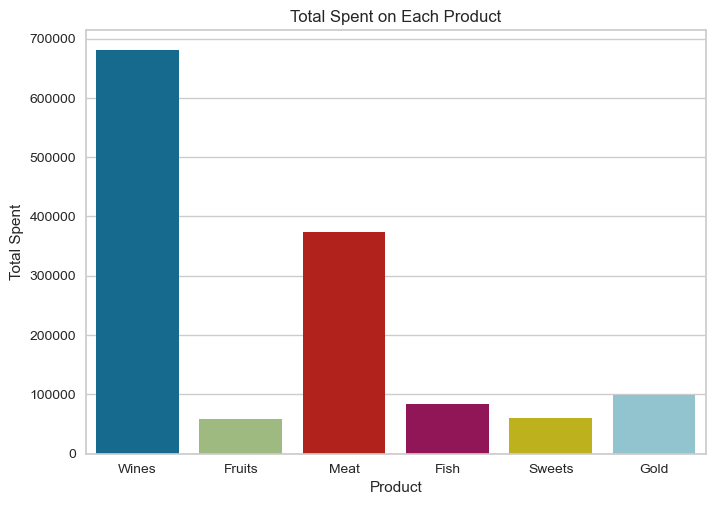

In [854]:
# Crear el gráfico de barras
sns.barplot(x='Product', y='Total', data=totals_df)


plt.xlabel('Product')
plt.ylabel('Total Spent')
plt.title('Total Spent on Each Product')


plt.show()

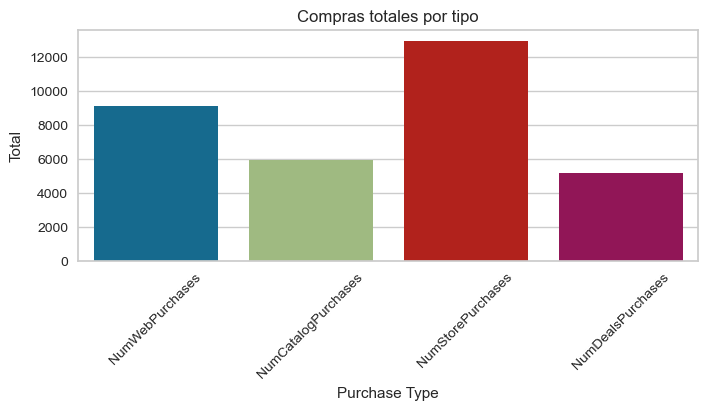

In [855]:
totals = {
    'Purchase Type': ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumDealsPurchases'],
    'Total Purchases': [
        df['NumWebPurchases'].sum(),
        df['NumCatalogPurchases'].sum(),
        df['NumStorePurchases'].sum(),
        df['NumDealsPurchases'].sum()
    ]
}

df_totals = pd.DataFrame(totals)

# Create the bar chart
plt.figure(figsize=(8, 3))
sns.barplot(x='Purchase Type', y='Total Purchases', data=df_totals)
plt.title('Compras totales por tipo')

plt.ylabel('Total')
plt.xticks(rotation=45)  # Rotates labels to avoid overlap
plt.show()

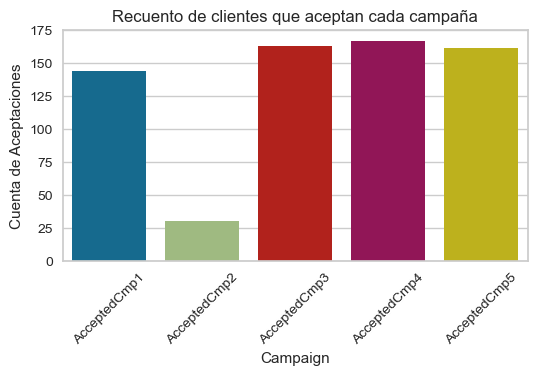

In [856]:
# Campañas 
campaigns = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
counts = df[campaigns].sum().reset_index()
counts.columns = ['Campaign', 'Cuenta de Aceptaciones']

# Create the bar chart
plt.figure(figsize=(6, 3))
sns.barplot(x='Campaign', y='Cuenta de Aceptaciones', data=counts)
plt.title('Recuento de clientes que aceptan cada campaña')
plt.xlabel('Campaign')
plt.ylabel('Cuenta de Aceptaciones')
plt.xticks(rotation=45)  
plt.show()

#### DATA PREPROCESSING

- Label encoding 
- Scaling 
- Dimensionality reduction

In [857]:
s = (df.dtypes == 'object')
object_cols = list(s[s].index)

print("variables categoricas :", object_cols)

variables categoricas : ['Education', 'Marital_Status']


In [858]:
LE=LabelEncoder()
for i in object_cols:
    df[i]=df[[i]].apply(LE.fit_transform)
    


In [859]:
df.head()

,Education,Marital_Status,Income,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Spent,Children,year_Dt
0,0,1,58138.0,58,635,88,546,172,88,88,...,0,0,0,0,0,1,67,1617,0,2012
1,0,1,46344.0,38,11,1,6,2,1,6,...,0,0,0,0,0,0,70,27,2,2014
2,0,0,71613.0,26,426,49,127,111,21,42,...,0,0,0,0,0,0,59,776,0,2013
3,0,0,26646.0,26,11,4,20,10,3,5,...,0,0,0,0,0,0,40,53,1,2014
4,1,0,58293.0,94,173,43,118,46,27,15,...,0,0,0,0,0,0,43,422,1,2014


In [860]:
df['Education'].unique()

array([0, 1, 2])

In [861]:
#Copia

ds = df.copy()


In [862]:
ds.head()

,Education,Marital_Status,Income,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Spent,Children,year_Dt
0,0,1,58138.0,58,635,88,546,172,88,88,...,0,0,0,0,0,1,67,1617,0,2012
1,0,1,46344.0,38,11,1,6,2,1,6,...,0,0,0,0,0,0,70,27,2,2014
2,0,0,71613.0,26,426,49,127,111,21,42,...,0,0,0,0,0,0,59,776,0,2013
3,0,0,26646.0,26,11,4,20,10,3,5,...,0,0,0,0,0,0,40,53,1,2014
4,1,0,58293.0,94,173,43,118,46,27,15,...,0,0,0,0,0,0,43,422,1,2014


In [863]:
# Identificar columnas continuas y binarias
continuous_cols = [ 'Income', 'Recency', 'Wines', 'Fruits',
       'Meat', 'Fish', 'Sweets', 'Gold','Age', 'Spent','year_Dt','Children','Education']
binary_cols = [ 'Marital_Status', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response']

In [864]:
# Escalar las características continuas
scaler = StandardScaler()
ds[continuous_cols] = scaler.fit_transform(ds[continuous_cols])


In [865]:
ds.head()

,Education,Marital_Status,Income,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Spent,Children,year_Dt
0,-0.89438,1,0.288513,0.306856,0.983228,1.554170,1.679746,2.461068,1.475396,0.845669,...,0,0,0,0,0,1,1.016868,1.680176,-1.264308,-1.500981
1,-0.89438,1,-0.262438,-0.383971,-0.871064,-0.636431,-0.713455,-0.650414,-0.631638,-0.729742,...,0,0,0,0,0,0,1.273264,-0.962202,1.395139,1.419988
2,-0.89438,0,0.917992,-0.798467,0.362159,0.572177,-0.177201,1.344595,-0.147262,-0.038098,...,0,0,0,0,0,0,0.333146,0.282541,-1.264308,-0.040496
3,-0.89438,0,-1.182621,-0.798467,-0.871064,-0.560893,-0.651409,-0.503991,-0.583200,-0.748954,...,0,0,0,0,0,0,-1.290693,-0.918994,0.065416,1.419988
4,0.57070,0,0.295754,1.550344,-0.389661,0.421101,-0.217088,0.154911,-0.001950,-0.556831,...,0,0,0,0,0,0,-1.034298,-0.305762,0.065416,1.419988


#### Dimensionality reduction con with PCA

Realizaré una reducción de dimensionalidad antes de entrenar K-means y AgglomerativeClustering.

Nuestro dataset cuenta con muchas columnas y los datos pueden volverse muy complejos y difíciles de manejar. PCA mantiene la mayor parte de la información relevante, lo que simplifica el problema y reduce el costo computacional.

In [866]:
pca = PCA()
PCA_ds = pd.DataFrame(pca.fit_transform(ds), index=ds.index, columns=[f'Component {i}' for i in range(pca.n_components_)])
PCA_ds.head()

,Component 0,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,...,Component 16,Component 17,Component 18,Component 19,Component 20,Component 21,Component 22,Component 23,Component 24,Component 25
0,5.316382,-1.373540,7.696804,0.192450,2.176985,-0.971789,-0.900142,-0.394639,-1.108783,0.580566,...,0.654015,-0.335865,0.132195,0.015502,-0.500318,0.085838,0.000359,0.002984,-0.011642,-1.342150e-15
1,-4.963986,2.312154,0.514578,-0.328084,-1.691824,0.797429,-0.874055,-1.350584,-0.624080,0.683327,...,0.644391,-0.013255,-0.154936,0.034246,0.002473,-0.043699,0.023559,0.003570,-0.012215,3.986483e-16
2,4.552121,-1.670484,-2.845680,2.813981,-0.037830,-0.012072,0.069470,-1.013429,0.074269,-0.293465,...,-0.358751,0.577551,-0.073417,-0.147467,-0.033074,-0.006336,0.026337,0.010157,-0.010852,-1.252786e-14
3,-4.317517,0.790590,-1.172238,0.122401,-0.201220,-0.356302,0.393259,-1.212099,1.538462,0.443168,...,-0.362422,-0.355821,-0.021611,0.038973,-0.059392,-0.023620,-0.000710,-0.000040,-0.008760,7.860477e-16
4,0.543063,-1.307441,0.406790,-1.191387,-1.909596,-0.531178,-0.003834,1.449659,1.628255,1.402239,...,-0.288036,0.494511,0.098352,-0.041123,-0.111550,-0.024540,0.015758,0.012407,-0.005366,1.405952e-14


In [867]:
## Esta función grafica la relación de varianza explicada acumulada para un objeto PCA ajustado
from itertools import accumulate

def plot_explained_variance(pca):
    acc = [*accumulate(pca.explained_variance_ratio_)]
    fig, ax = plt.subplots(1, figsize=(50, 20))
    ax.stackplot(range(pca.n_components_), acc)
    ax.scatter(range(pca.n_components_), acc, color='black')
    ax.set_ylim(0, 1)
    ax.set_xlim(0, pca.n_components_-1)
    ax.tick_params(axis='both', labelsize=36)
    ax.set_xlabel('N Components', fontsize=48)
    ax.set_ylabel('Accumulated explained variance', fontsize=48)
    plt.tight_layout()
    plt.show()

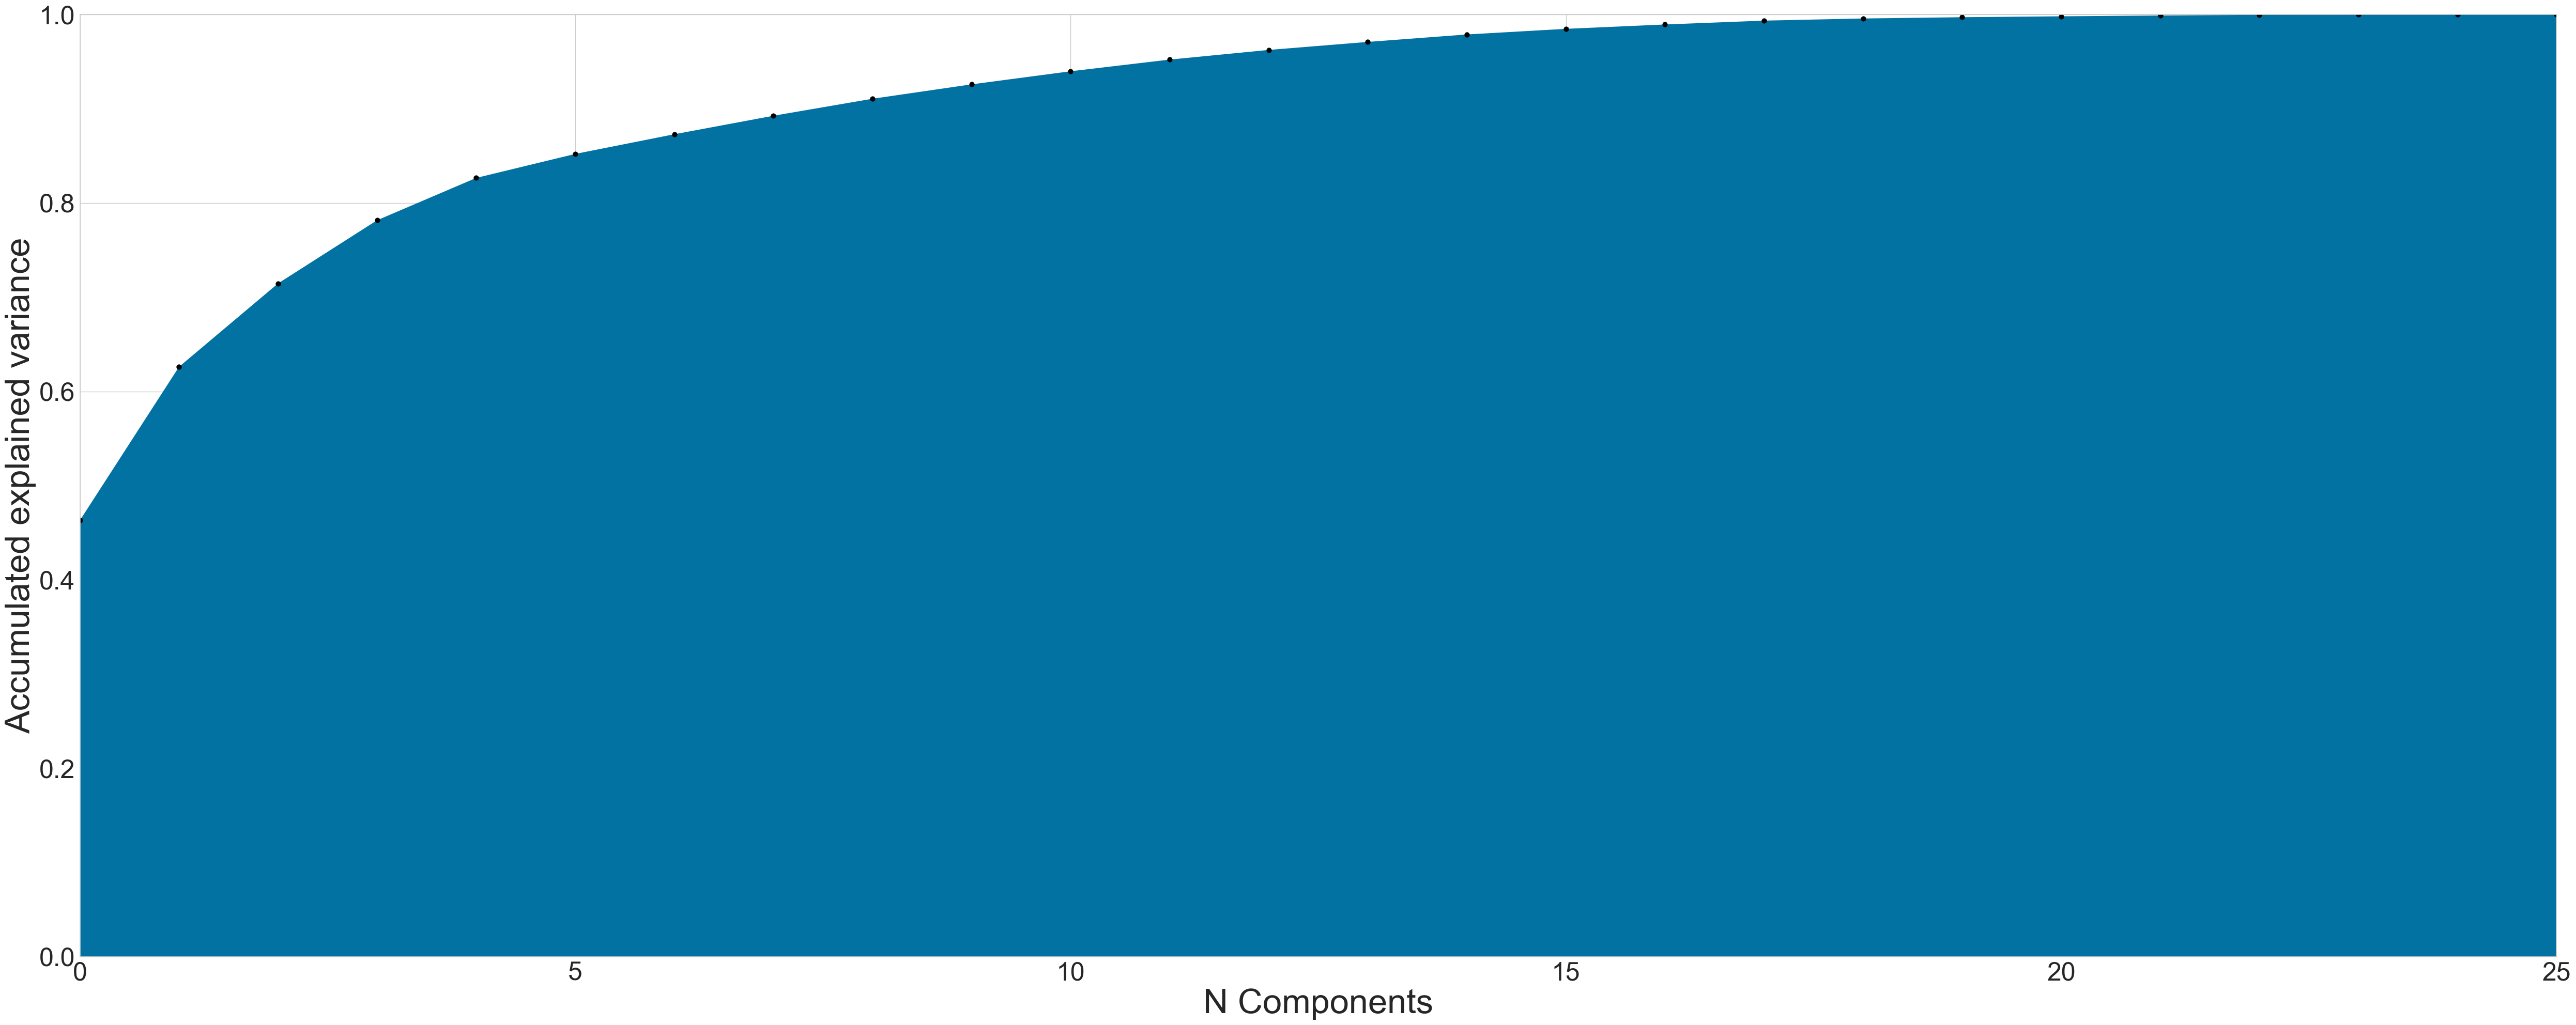

In [868]:
plot_explained_variance(pca)

In [869]:
# Nos quedamos con el 85% de varianza explicada 
threshold = 0.85
num = next(i for i, x in enumerate(accumulate(pca.explained_variance_ratio_), 1) if x >= threshold)
print(f'Podemos retener los {num} componentes y descartar {pca.n_components_-num},')
print(f'Manteniendo  >={100 * threshold}%  de la varianza explicada!')

Podemos retener los 6 componentes y descartar 20,
Manteniendo  >=85.0%  de la varianza explicada!


In [870]:
PCA_ds.drop([f'Component {i}' for i in range(num, pca.n_components_)], axis=1, inplace=True)
PCA_ds.head()

,Component 0,Component 1,Component 2,Component 3,Component 4,Component 5
0,5.316382,-1.373540,7.696804,0.192450,2.176985,-0.971789
1,-4.963986,2.312154,0.514578,-0.328084,-1.691824,0.797429
2,4.552121,-1.670484,-2.845680,2.813981,-0.037830,-0.012072
3,-4.317517,0.790590,-1.172238,0.122401,-0.201220,-0.356302
4,0.543063,-1.307441,0.406790,-1.191387,-1.909596,-0.531178


In [871]:
PCA_ds.corr().style.background_gradient(cmap='coolwarm')

,Component 0,Component 1,Component 2,Component 3,Component 4,Component 5
Component 0,1.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000
Component 1,0.000000,1.000000,0.000000,-0.000000,0.000000,0.000000
Component 2,-0.000000,0.000000,1.000000,-0.000000,-0.000000,-0.000000
Component 3,0.000000,-0.000000,-0.000000,1.000000,0.000000,-0.000000
Component 4,0.000000,0.000000,-0.000000,0.000000,1.000000,0.000000
Component 5,-0.000000,0.000000,-0.000000,-0.000000,0.000000,1.000000


Como puede ver, las correlaciones de los 6 componentes principales ahora son cero, lo que significa que hemos descorrelacionado  con éxito y hemos obtenido características que son linealmente independientes entre sí.

In [872]:
components_ = df.columns[0:6]

comp_df_b = pd.DataFrame(list(zip(components_,pca.explained_variance_ratio_*100)),columns=["Componentes","Contribucion"])

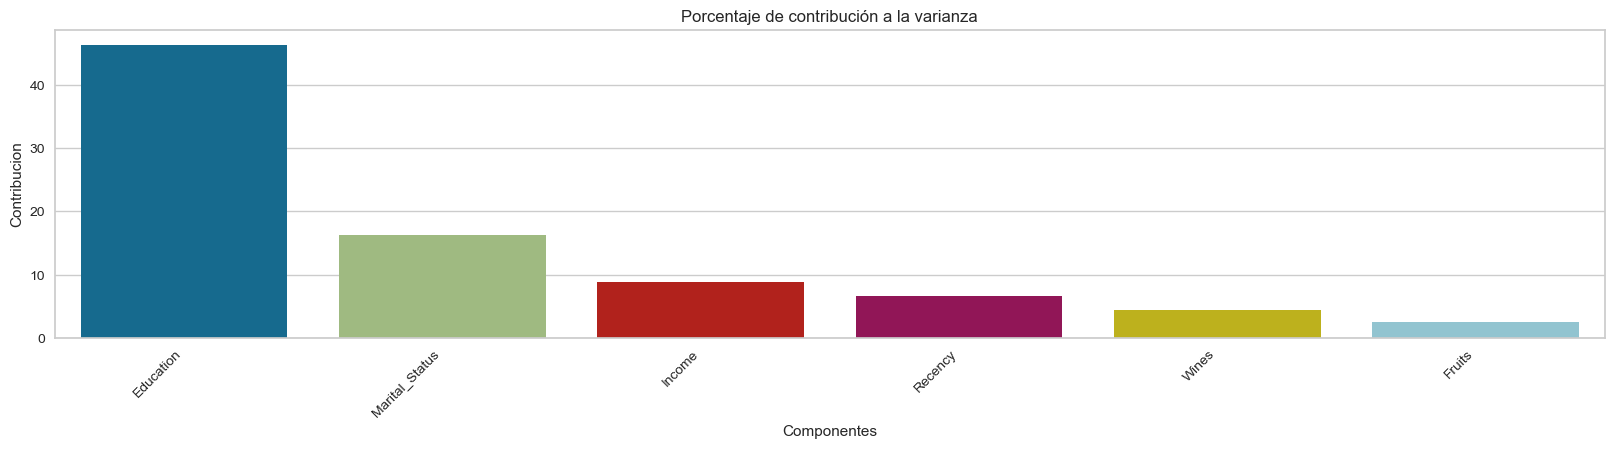

In [873]:
plt.figure(figsize=(20, 4))

# Crear el gráfico de barras
ax = sns.barplot(
    data=comp_df_b,
    x="Componentes", 
    y="Contribucion"
)

# Rotar las etiquetas del eje x
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Añadir título al gráfico
plt.title("Porcentaje de contribución a la varianza")

# Mostrar el gráfico
plt.show()

#### Clustering

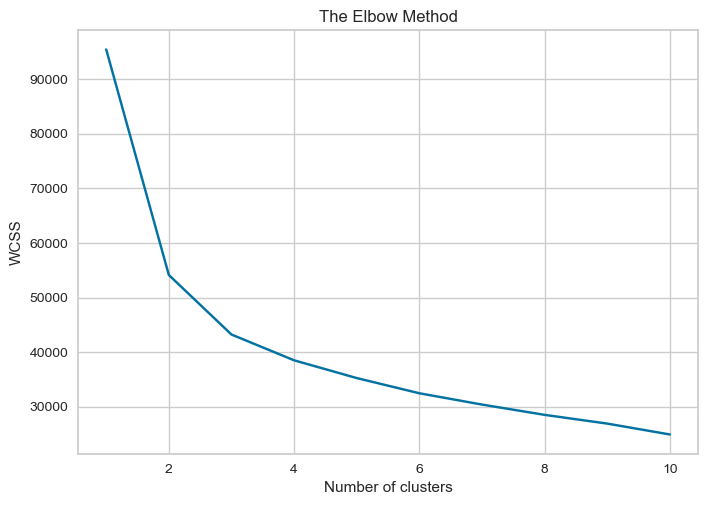

In [874]:
# Metodo del Codo para encontrar el numero optimo de clusters
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(PCA_ds)
    wcss.append(kmeans.inertia_)

# Grafica de la suma de las distancias
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Elbow Method


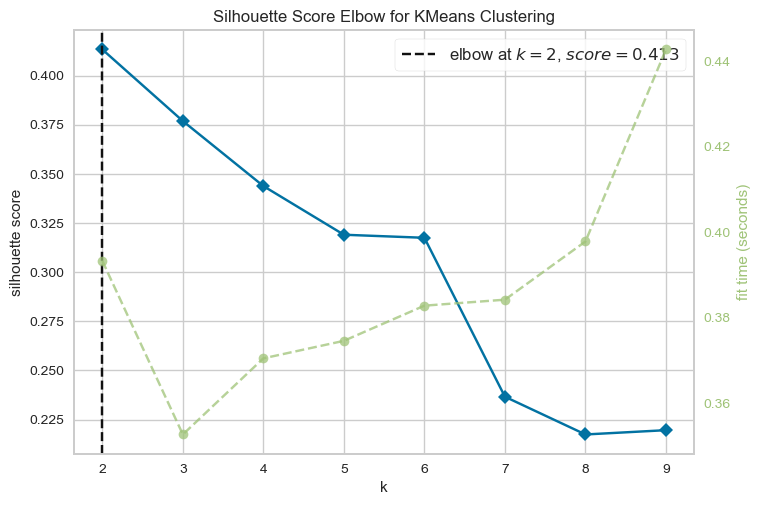

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [875]:
print('Elbow Method')
Elbow_M = KElbowVisualizer(KMeans(init = 'k-means++', random_state = 42), k=(2,10), metric= 'silhouette')
Elbow_M.fit(PCA_ds)
Elbow_M.show()

In [876]:
from sklearn.metrics import silhouette_score
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, init = 'k-means++', random_state = 42)
    kmeans.fit(PCA_ds)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(PCA_ds, labels)
    print(f"For k = {k}, the average silhouette score is {silhouette_avg:.2f}")
    
#valores más altos de Silhouette indican una mejor separación entre los grupos.

For k = 2, the average silhouette score is 0.41
For k = 3, the average silhouette score is 0.38
For k = 4, the average silhouette score is 0.34
For k = 5, the average silhouette score is 0.32
For k = 6, the average silhouette score is 0.32
For k = 7, the average silhouette score is 0.24
For k = 8, the average silhouette score is 0.22
For k = 9, the average silhouette score is 0.22


In [877]:
# Creando el k-Means para los 2 grupos encontrados
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42) #k-means++ acelera la convergencia, respecto de random
y_kmeans = kmeans.fit_predict(PCA_ds)

In [878]:
y_kmeans

array([0, 1, 0, ..., 0, 0, 1])

In [879]:
ds['pred']=y_kmeans
ds.head()

,Education,Marital_Status,Income,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Spent,Children,year_Dt,pred
0,-0.89438,1,0.288513,0.306856,0.983228,1.554170,1.679746,2.461068,1.475396,0.845669,...,0,0,0,0,1,1.016868,1.680176,-1.264308,-1.500981,0
1,-0.89438,1,-0.262438,-0.383971,-0.871064,-0.636431,-0.713455,-0.650414,-0.631638,-0.729742,...,0,0,0,0,0,1.273264,-0.962202,1.395139,1.419988,1
2,-0.89438,0,0.917992,-0.798467,0.362159,0.572177,-0.177201,1.344595,-0.147262,-0.038098,...,0,0,0,0,0,0.333146,0.282541,-1.264308,-0.040496,0
3,-0.89438,0,-1.182621,-0.798467,-0.871064,-0.560893,-0.651409,-0.503991,-0.583200,-0.748954,...,0,0,0,0,0,-1.290693,-0.918994,0.065416,1.419988,1
4,0.57070,0,0.295754,1.550344,-0.389661,0.421101,-0.217088,0.154911,-0.001950,-0.556831,...,0,0,0,0,0,-1.034298,-0.305762,0.065416,1.419988,0


#### Agglomerative Clustering model 

Elbow Method


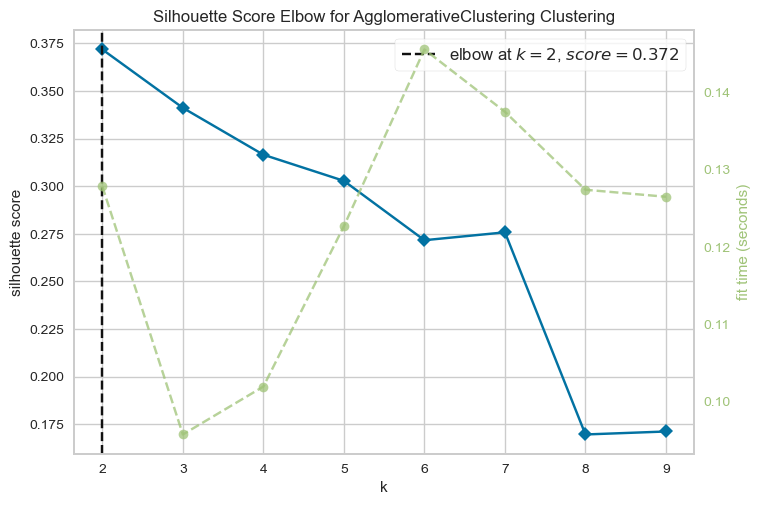

<Axes: title={'center': 'Silhouette Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='silhouette score'>

In [880]:
print('Elbow Method')
Elbow_M = KElbowVisualizer(AgglomerativeClustering(affinity= 'euclidean', linkage='ward'), k=(2,10), metric= 'silhouette')
Elbow_M.fit(PCA_ds)
Elbow_M.show()

In [881]:

AC = AgglomerativeClustering(n_clusters=2, affinity= 'euclidean', linkage='ward')

agg = AC.fit_predict(PCA_ds)


In [882]:
PCA_ds["Clusters"] = agg

ds["Clusters"] = agg

In [883]:
ds.head()

,Education,Marital_Status,Income,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Spent,Children,year_Dt,pred,Clusters
0,-0.89438,1,0.288513,0.306856,0.983228,1.554170,1.679746,2.461068,1.475396,0.845669,...,0,0,0,1,1.016868,1.680176,-1.264308,-1.500981,0,0
1,-0.89438,1,-0.262438,-0.383971,-0.871064,-0.636431,-0.713455,-0.650414,-0.631638,-0.729742,...,0,0,0,0,1.273264,-0.962202,1.395139,1.419988,1,1
2,-0.89438,0,0.917992,-0.798467,0.362159,0.572177,-0.177201,1.344595,-0.147262,-0.038098,...,0,0,0,0,0.333146,0.282541,-1.264308,-0.040496,0,0
3,-0.89438,0,-1.182621,-0.798467,-0.871064,-0.560893,-0.651409,-0.503991,-0.583200,-0.748954,...,0,0,0,0,-1.290693,-0.918994,0.065416,1.419988,1,1
4,0.57070,0,0.295754,1.550344,-0.389661,0.421101,-0.217088,0.154911,-0.001950,-0.556831,...,0,0,0,0,-1.034298,-0.305762,0.065416,1.419988,0,0


#### Evaluating the Models

Dado que se trata de una agrupación no supervisada,no tenemos una etiqueta para evaluar o calificar nuestro modelo.

El propósito de esta sección es utilizar algunas metricas que nos permitan quedarnos con el mejor modelo, es decir, aquel que mejor logro captar los patrones en los datos para formar los clusters.


**En primer lugar, echemos un vistazo a la distribución de cada grupo para cada modelo entrenado**

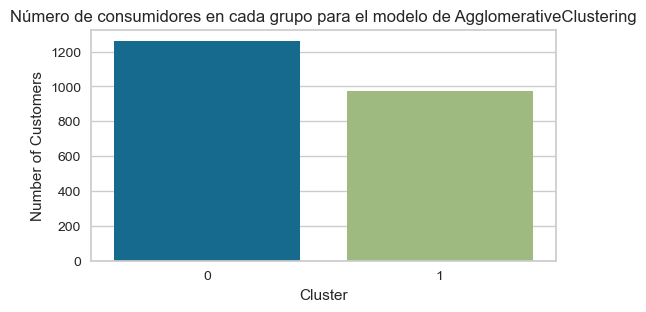

In [884]:

plt.figure(figsize=(6, 3))
sns.countplot(x='Clusters', data=ds)
plt.title('Número de consumidores en cada grupo para el modelo de AgglomerativeClustering')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()

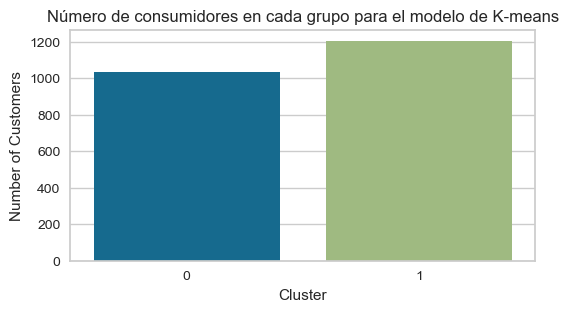

In [885]:
plt.figure(figsize=(6, 3))
sns.countplot(x='pred', data=ds)
plt.title('Número de consumidores en cada grupo para el modelo de K-means')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()

**El Índice Davies-Bouldin evalúa la relación entre la dispersión dentro de los clusters y la separación entre los clusters. Valores más bajos indican mejores clusters.**

In [886]:
from sklearn.metrics import davies_bouldin_score

# Calcular el Índice Davies-Bouldin para ambos conjuntos de etiquetas
db_score1 = davies_bouldin_score(PCA_ds,y_kmeans)
db_score2 = davies_bouldin_score(PCA_ds,agg)

print(f'Davies-Bouldin Score K-Means: {db_score1}')
print(f'Davies-Bouldin Score AgglomerativeClustering: {db_score2}')


Davies-Bouldin Score K-Means: 1.023053985097906
Davies-Bouldin Score AgglomerativeClustering: 1.0030826798011996


  AgglomerativeClustering tiene un score mas bajo que K-Means 

**Calinski-Harabasz Index (Variance Ratio Criterion)**
El Índice Calinski-Harabasz mide la dispersión dentro de los clusters y entre los clusters. Valores más altos indican mejores clusters.

In [887]:
from sklearn.metrics import calinski_harabasz_score

# Calcular el Índice Calinski-Harabasz para ambos modelos
ch_score1 = calinski_harabasz_score(PCA_ds,y_kmeans)
ch_score2 = calinski_harabasz_score(PCA_ds,agg)

print(f'Calinski-Harabasz Score K-Means: {ch_score1}')
print(f'Calinski-Harabasz Score AgglomerativeClustering: {ch_score2}')


Calinski-Harabasz Score K-Means: 1714.1205538000368
Calinski-Harabasz Score AgglomerativeClustering: 1504.4453937555797


AgglomerativeClustering para Calinski-Harabasz tiene un score mas alto que  K-Means, indicando una mejor agrupación.

#### Conlusión

En este proyecto, he analizado un conjunto de datos de clientes mediante la creación de clusters. El flujo de trabajo abarcó limpieza de datos, ingeniería de funciones, gestión de valores atípicos y análisis exploratorios de datos.
Luego continué con el preprocesamiento de datos, que incluía codificación de etiquetas para características categóricas, escalado de todas las características y reducción de dimensionalidad mediante PCA.

Durante la fase de aprendizaje automático, utilizamos el método Elbow para determinar el número óptimo de clústeres (K) para los algoritmos KMeans y AgglomerativeClustering.

Después de ajustar los modelos y evaluarlos podemos concluir que AgglomerativeClustering performo mejor para los distintos perfiles de cada grupo, revelando patrones en el comportamiento del consumidor.

#### Recomendaciones futuras

Para mejorar la solidez y aplicabilidad de nuestros hallazgos, podriamos profundizar analizando la distribución de las distintas variables como edad, ingreso, estado civil, productos comprados etc. para cada grupo. 

